In [1]:
import sys
print(sys.version, sys.platform, sys.executable)

3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)] win32 C:\Users\arupatil\Anaconda3\envs\aif360\python.exe


In [63]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from matplotlib import pyplot as plt

import sys
sys.path.append("../")
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from aif360.algorithms.preprocessing import DisparateImpactRemover
# The dataset used is from the AI360 datasets
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric


### Compas Dataset

The CompasDataset expects you to specify the label (target) variable, by default it is 'two_year_recid'

```aif360.datasets.CompasDataset(label_name='two_year_recid', favorable_classes=[0], protected_attribute_names=['sex', 'race'], privileged_classes=[['Female'], ['Caucasian']], instance_weights_name=None, categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc'], features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], features_to_drop=[], na_values=[], custom_preprocessing=<function default_preprocessing>, metadata={'label_maps': [{0.0: 'No recid.', 1.0: 'Did recid.'}], 'protected_attribute_maps': [{0.0: 'Male', 1.0: 'Female'}, {0.0: 'Not Caucasian', 1.0: 'Caucasian'}]})```

In [65]:
protected = 'race'
cp = CompasDataset(
    label_name='two_year_recid',
    protected_attribute_names=[protected],
    privileged_classes = [['Caucasian']], 
    categorical_features=['sex','age_cat'],
    features_to_keep=['sex', 'age', 'age_cat', 'race','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', #'c_charge_degree', 
                      'two_year_recid'])

In [66]:
cp #display

               instance weights features                                    \
                                         protected attribute                 
                                     age                race juv_fel_count   
instance names                                                               
1                           1.0     69.0                 0.0           0.0   
3                           1.0     34.0                 0.0           0.0   
4                           1.0     24.0                 0.0           0.0   
7                           1.0     44.0                 0.0           0.0   
8                           1.0     41.0                 1.0           0.0   
9                           1.0     43.0                 0.0           0.0   
10                          1.0     39.0                 1.0           0.0   
14                          1.0     27.0                 1.0           0.0   
15                          1.0     23.0                 0.0    

In [67]:
type(cp)

aif360.datasets.compas_dataset.CompasDataset

### Train and Test split

### ------------Model 1: Logistic Regression before employing Disparate Impact Remover-------------

In [68]:
#Converting train and test to Pandas

data_train=train.convert_to_dataframe()
df_train=pd.DataFrame(data_train[0])

data_test=test.convert_to_dataframe()
df_test=pd.DataFrame(data_test[0])

In [69]:
#Shape of Train and Test 

display(df_train.shape)
display(df_test.shape)

(4320, 14)

(1852, 14)

In [70]:
#converting from float to int
#Train

df_train['age']=df_train['age'].astype('int64')
df_train['race']=df_train[ 'race'].astype('int64')
df_train['juv_fel_count']=df_train['juv_fel_count'].astype('int64')
df_train['decile_score']=df_train['decile_score'].astype('int64')
df_train['decile_score_binary']=df_train['decile_score_binary'].astype('int64')
df_train['juv_misd_count']=df_train['juv_misd_count'].astype('int64')
df_train['juv_other_count']=df_train['juv_other_count'].astype('int64')
df_train['priors_count']=df_train['priors_count'].astype('int64')
df_train['sex=Female']=df_train['sex=Female'].astype('int64')
df_train['sex=Male']=df_train['sex=Male'].astype('int64')
df_train['age_cat=25 - 45']=df_train['age_cat=25 - 45'].astype('int64')
df_train['age_cat=Greater than 45']=df_train['age_cat=Greater than 45'].astype('int64')
df_train['age_cat=Less than 25']=df_train['age_cat=Less than 25'].astype('int64')
#df_train['c_charge_degree=F']=df_train['c_charge_degree=F'].astype('int64')
#df_train['c_charge_degree=M']=df_train['c_charge_degree=M'].astype('int64')
df_train['two_year_recid']=df_train['two_year_recid'].astype('int64')


In [71]:
#converting from float to int
#Test

df_test['age']=df_test['age'].astype('int64')
df_test['race']=df_test[ 'race'].astype('int64')
df_test['juv_fel_count']=df_test['juv_fel_count'].astype('int64')
df_test['decile_score']=df_test['decile_score'].astype('int64')
df_test['decile_score_binary']=df_test['decile_score_binary'].astype('int64')
df_test['juv_misd_count']=df_test['juv_misd_count'].astype('int64')
df_test['juv_other_count']=df_test['juv_other_count'].astype('int64')
df_test['priors_count']=df_test['priors_count'].astype('int64')
df_test['sex=Female']=df_test['sex=Female'].astype('int64')
df_test['sex=Male']=df_test['sex=Male'].astype('int64')
df_test['age_cat=25 - 45']=df_test['age_cat=25 - 45'].astype('int64')
df_test['age_cat=Greater than 45']=df_test['age_cat=Greater than 45'].astype('int64')
df_test['age_cat=Less than 25']=df_test['age_cat=Less than 25'].astype('int64')
#df_test['c_charge_degree=F']=df_test['c_charge_degree=F'].astype('int64')
#df_test['c_charge_degree=M']=df_test['c_charge_degree=M'].astype('int64')
df_test['two_year_recid']=df_test['two_year_recid'].astype('int64')

In [72]:
#Train
xTrain=df_train.drop(['decile_score_binary', 'decile_score', 'two_year_recid'], axis=1)
yTrain=df_train['decile_score_binary']

#Test
xTest=df_test.drop(['decile_score_binary', 'decile_score', 'two_year_recid'], axis=1)
yTest=df_test['decile_score_binary']

In [73]:
#model
classifier=LogisticRegression()
classifier.fit(xTrain, yTrain)

C:\Users\arupatil\Anaconda3\envs\aif360\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [74]:
#predict
yPred=classifier.predict(xTest)

In [75]:
Final=df_test.copy() #Storing test to a new dataset

In [76]:
Final['true_risk'] = Final['two_year_recid'] #ground truth

In [77]:
Final['pred_risk']=yPred #predicted decile score binary #appending the predicted labels to the final dataset

In [78]:
Final.head()

,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid,sex=Female,sex=Male,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,decile_score_binary,true_risk,pred_risk
7997,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0
8038,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
8634,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
8189,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3250,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


### Plots

In [79]:
def plot(race_ind = 1):
    a=Final[Final['race'] == race_ind] #subsetting{ race=1 is Caucasian }
    print(a.shape)
    a1=a['pred_risk'].value_counts().reset_index().rename(columns={'index':'Pred_Risk', 'pred_risk':'Number_of_Defendants'}).sort_values(by=['Pred_Risk'])['Number_of_Defendants'].values
    a2=a['true_risk'].value_counts().reset_index().rename(columns={'index':'True_Risk', 'true_risk':'Number_of_Defendants'}).sort_values(by=['True_Risk'])['Number_of_Defendants'].values
    print(a1)
    print(a2)
    
    ind = np.arange(len(a1))
    width = 0.35
    
    fig, ax = plt.subplots()
    ax1 = ax.bar(ind - width/2, a1, width, color='Blue', label='Predicted Risk')
    ax2 = ax.bar(ind + width/2, a2, width, color='Red', label='Actual Risk')
    
    ax.set_ylabel('# of Defendants', fontsize=15)
    ax.set_xlabel('Decile Score', fontsize=15)
    if race_ind == 1:
        ax.set_title("Distribution of Risk Score for Caucasians", fontsize=15)
    if race_ind == 0:
        ax.set_title("Distribution of Risk Score for Non-Caucasians", fontsize=15)
    ax.set_xticks(ind)
    ax.set_xticklabels(('Low Risk', 'High Risk'))
    ax.legend()
    
    plt.show()

(632, 16)
[632]
[403 229]


C:\Users\arupatil\Anaconda3\envs\aif360\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


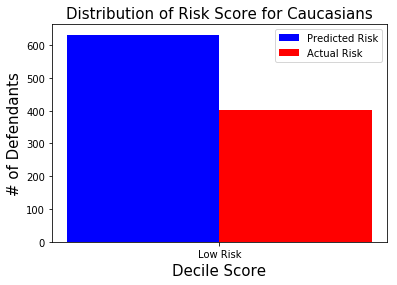

In [80]:
plot(1)

(1220, 16)
[1219    1]
[628 592]


C:\Users\arupatil\Anaconda3\envs\aif360\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


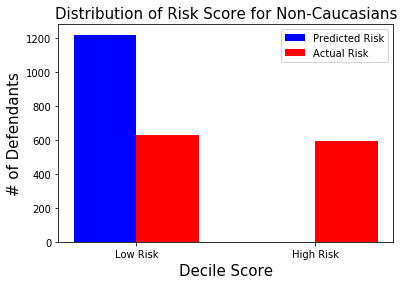

In [81]:
plot(0)

### Accuracy

In [82]:
# Prediction Accuracy

accuracy_score(Final['true_risk'], Final['pred_risk'])

0.5572354211663066

In [83]:
# Prediction Accuracy for Caucasians
c1=Final[Final['race']==1]

accuracy_score(c1['true_risk'], c1['pred_risk'])

0.6376582278481012

In [84]:
# Prediction Accuracy for Non-Caucasians
c2=Final[Final['race']==0]

accuracy_score(c2['true_risk'], c2['pred_risk'])

0.5155737704918033

In [85]:
classifier.score(xTest,yTest) #model accuracy

0.7397408207343412

In [86]:
classifier.score(xTest[xTest["race"] == 1],yTest[xTest["race"] == 1]) #Caucasians

0.8544303797468354

In [87]:
classifier.score(xTest[xTest["race"] == 0],yTest[xTest["race"] == 0])

0.680327868852459

### ----------------Model 2: Logistic Regression after employing Disparate Impact Remover---------------

In [88]:
display(Markdown("#### Training Dataset shape"))
print(train.features.shape)

#### Training Dataset shape

(4320, 13)


In [89]:
display(Markdown("#### Protected attribute names"))
print(train.protected_attribute_names)

#### Protected attribute names

['race']


In [90]:
display(Markdown("#### Label names"))
print(train.label_names)

#### Label names

['decile_score_binary']


In [91]:
display(Markdown("#### Dataset feature names"))
print(train.feature_names)

#### Dataset feature names

['age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count', 'priors_count', 'two_year_recid', 'sex=Female', 'sex=Male', 'age_cat=25 - 45', 'age_cat=Greater than 45', 'age_cat=Less than 25']


In [92]:
#applying Disparate Impact Remover

di = DisparateImpactRemover(repair_level=1.0)

train_repd = di.fit_transform(train)
test_repd = di.fit_transform(test)

In [93]:
#Convert to Pandas after applying Disparate Impact Remover

#Train
data1=train_repd.convert_to_dataframe()
train_di=pd.DataFrame(data1[0])


#Test
data2=test_repd.convert_to_dataframe()
test_di=pd.DataFrame(data2[0])

In [94]:
display(train_di.shape)
display(test_di.shape)

(4320, 14)

(1852, 14)

In [95]:
#converting from float to int
#Train

train_di['age']=train_di['age'].astype('int64')
train_di['race']=train_di[ 'race'].astype('int64')
train_di['juv_fel_count']=train_di['juv_fel_count'].astype('int64')
train_di['decile_score']=train_di['decile_score'].astype('int64')
train_di['decile_score_binary']=train_di['decile_score_binary'].astype('int64')
train_di['juv_misd_count']=train_di['juv_misd_count'].astype('int64')
train_di['juv_other_count']=train_di['juv_other_count'].astype('int64')
train_di['priors_count']=train_di['priors_count'].astype('int64')
train_di['sex=Female']=train_di['sex=Female'].astype('int64')
train_di['sex=Male']=train_di['sex=Male'].astype('int64')
train_di['age_cat=25 - 45']=train_di['age_cat=25 - 45'].astype('int64')
train_di['age_cat=Greater than 45']=train_di['age_cat=Greater than 45'].astype('int64')
train_di['age_cat=Less than 25']=train_di['age_cat=Less than 25'].astype('int64')
#train_di['c_charge_degree=F']=train_di['c_charge_degree=F'].astype('int64')
#train_di['c_charge_degree=M']=train_di['c_charge_degree=M'].astype('int64')
train_di['two_year_recid']=train_di['two_year_recid'].astype('int64')

In [96]:
#Test
test_di['age']=test_di['age'].astype('int64')
test_di['race']=test_di[ 'race'].astype('int64')
test_di['juv_fel_count']=test_di['juv_fel_count'].astype('int64')
test_di['decile_score']=test_di['decile_score'].astype('int64')
test_di['decile_score_binary']=test_di['decile_score_binary'].astype('int64')
test_di['juv_misd_count']=test_di['juv_misd_count'].astype('int64')
test_di['juv_other_count']=test_di['juv_other_count'].astype('int64')
test_di['priors_count']=test_di['priors_count'].astype('int64')
test_di['sex=Female']=test_di['sex=Female'].astype('int64')
test_di['sex=Male']=test_di['sex=Male'].astype('int64')
test_di['age_cat=25 - 45']=test_di['age_cat=25 - 45'].astype('int64')
test_di['age_cat=Greater than 45']=test_di['age_cat=Greater than 45'].astype('int64')
test_di['age_cat=Less than 25']=test_di['age_cat=Less than 25'].astype('int64')
#test_di['c_charge_degree=F']=test_di['c_charge_degree=F'].astype('int64')
#test_di['c_charge_degree=M']=test_di['c_charge_degree=M'].astype('int64')
test_di['two_year_recid']=test_di['two_year_recid'].astype('int64')

In [97]:
#Creating features and labels

#Train
xTrain_di=train_di.drop(['decile_score_binary', 'decile_score', 'two_year_recid'], axis=1)
yTrain_di=train_di['decile_score_binary']

#Test
xTest_di=test_di.drop(['decile_score_binary', 'decile_score', 'two_year_recid'], axis=1)
yTest_di=test_di['decile_score_binary']


In [98]:
#model
lmod=LogisticRegression()
lmod.fit(xTrain_di, yTrain_di)

C:\Users\arupatil\Anaconda3\envs\aif360\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [99]:
#predict
yPred_di=classifier.predict(xTest_di)

In [100]:
Final_di=test_di.copy() #Storing xtest to a new dataset

In [101]:
Final_di['true_risk']= Final_di['two_year_recid'] #true risk

In [102]:
Final_di['pred_risk']=yPred_di #appending the predicted labels to the final dataset

In [103]:
Final_di.head()

,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid,sex=Female,sex=Male,age_cat=25 - 45,age_cat=Greater than 45,age_cat=Less than 25,decile_score_binary,true_risk,pred_risk
7997,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,0
8038,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
8634,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
8189,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3250,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0


### Plots

In [104]:
def plot(race_ind = 1):
    a=Final_di[Final_di['race'] == race_ind] #subsetting{ race=1 is Caucasian }
    print(a.shape)
    a1=a['pred_risk'].value_counts().reset_index().rename(columns={'index':'Pred_Risk', 'pred_risk':'Number_of_Defendants'}).sort_values(by=['Pred_Risk'])['Number_of_Defendants'].values
    a2=a['true_risk'].value_counts().reset_index().rename(columns={'index':'True_Risk', 'true_risk':'Number_of_Defendants'}).sort_values(by=['True_Risk'])['Number_of_Defendants'].values
    print(a1)
    print(a2)
    
    ind = np.arange(len(a1))
    width = 0.35
    
    fig, ax = plt.subplots()
    ax1 = ax.bar(ind - width/2, a1, width, color='Blue', label='Predicted Risk')
    ax2 = ax.bar(ind + width/2, a2, width, color='Red', label='Actual Risk')
    
    ax.set_ylabel('# of Defendants', fontsize=15)
    ax.set_xlabel('Decile Score', fontsize=15)
    if race_ind == 1:
        ax.set_title("Distribution of Risk Score for Caucasians", fontsize=15)
    if race_ind == 0:
        ax.set_title("Distribution of Risk Score for Non-Caucasians", fontsize=15)
    ax.set_xticks(ind)
    ax.set_xticklabels(('Low Risk', 'High Risk'))
    ax.legend()
    
    plt.show()

(632, 16)
[632]
[403 229]


C:\Users\arupatil\Anaconda3\envs\aif360\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


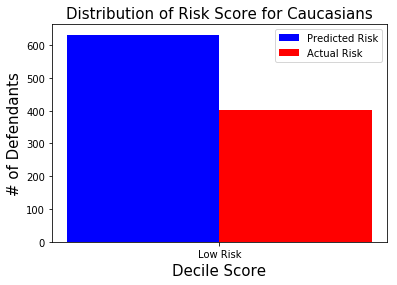

In [105]:
plot(1)

(1220, 16)
[1220]
[628 592]


C:\Users\arupatil\Anaconda3\envs\aif360\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


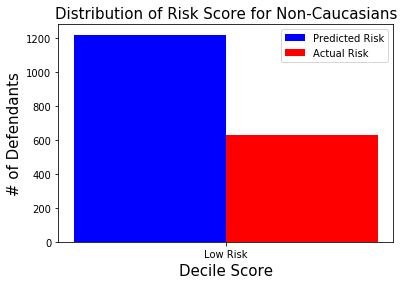

In [106]:
plot(0)

### Accuracy

In [107]:
# Prediction Accuracy
accuracy_score(Final_di['true_risk'], Final_di['pred_risk'])

0.556695464362851

In [108]:
# Prediction Accuracy for Caucasians
c1=Final_di[Final_di['race']==1]

accuracy_score(c1['true_risk'], c1['pred_risk'])

0.6376582278481012

In [109]:
# Prediction Accuracy for Non-Caucasians
c2=Final_di[Final_di['race']==0]

accuracy_score(c2['true_risk'], c2['pred_risk'])

0.5147540983606558

In [110]:
lmod.score(xTest_di,yTest_di) #model accuracy

0.7392008639308856

In [111]:
lmod.score(xTest_di[xTest_di["race"] == 1],yTest_di[xTest_di["race"] == 1]) #Caucasians

0.8544303797468354

In [112]:
lmod.score(xTest_di[xTest_di["race"] == 0],yTest_di[xTest_di["race"] == 0])  # Non=Causacians

0.6795081967213115